In [1]:
import numpy as np 
import pandas as pd
import os

from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, Dropout
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications import resnet50, densenet

from sklearn.model_selection import train_test_split

from keras.optimizers import RMSprop
from keras.applications import densenet

from skimage.transform import resize
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
from sklearn import metrics
#from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

import csv
import gc
import cv2

#print(os.listdir("../input/resnet50"))
#print(os.listdir("../input/densenet-keras/DenseNet-BC-121-32-no-top.h5"))

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
dados_treino = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
dados_teste = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

diagn_treino = pd.get_dummies(dados_treino['diagnosis']).values

In [3]:
def get_cropped_image(image):
    img = cv2.blur(image,(2,2))
    slice1Copy = np.uint8(img)
    canny = cv2.Canny(slice1Copy, 0, 50)
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    cropped_img = img[y1:y2, x1:x2]
    cropped_img = cv2.resize(cropped_img, size)
    return cropped_img

def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            #print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
            #print(img.shape)
        return img

In [4]:

def preprocess_image(image_path, desired_size=224, sigmaX=10):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(im)
    im=cv2.addWeighted (im,4, cv2.GaussianBlur(im, (0,0) , sigmaX) ,-4 ,128)
    im = cv2.resize(im, (desired_size, desired_size))
    #im = Image.resize((desired_size, )*2, resample=Image.LANCZOS)
    #image = crop_image_from_gray(im)
    #im = get_cropped_image(im)
    #plt.imshow(im, interpolation='nearest')
    #plt.show()
    #print(im.shape)
    return im


In [5]:
N = dados_treino.shape[0]
ident_treino = np.empty((N, 224, 224, 3), dtype=np.uint8)
for i, image_id in enumerate(tqdm(dados_treino['id_code'])):
    ident_treino[i, :, :, :] = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_id}.png')
  
N = dados_teste.shape[0]
ident_teste = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(dados_teste['id_code'])):
    ident_teste[i, :, :, :] = preprocess_image(f'../input/aptos2019-blindness-detection/test_images/{image_id}.png')

100%|██████████| 1928/1928 [04:17<00:00,  7.48it/s]


In [6]:
#diagn_treino_multilabel = np.empty(diagn_treino.shape, dtype=diagn_treino.dtype)
#diagn_treino_multilabel[:, 4] = diagn_treino[:, 4]

#for i in range(3, -1, -1):
   #diagn_treino_multilabel[:, i] = np.logical_or(diagn_treino[:, i], diagn_treino_multilabel[:, i+1])

#print("Original y_train:", diagn_treino.sum(axis=0))
#print("Multilabel version:", diagn_treino_multilabel.sum(axis=0))

In [7]:
ident_treino_train, ident_treino_val, diagn_treino_train, diagn_treino_val = train_test_split(
    ident_treino, diagn_treino,  
    test_size=0.15, 
    random_state=2019)


In [8]:
batch_size = 50
epochs = 200
data_augmentation = True

num_classes = 5
num_dense_blocks = 3

growth_rate = 12
depth = 100
num_bottleneck_layers = (depth - 4) // (2 * num_dense_blocks)

num_filters_bef_dense_block = 2 * growth_rate
compression_factor = 0.5

In [9]:
input_shape = ident_treino_train.shape[1:]
inputs = Input(shape=input_shape)
#base_model = resnet50.ResNet50(weights="../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5", input_tensor=inputs, input_shape=input_shape, include_top=False)
base_model = densenet.DenseNet121(include_top=False, weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5', input_tensor=inputs, input_shape=input_shape,
                                                     pooling=None, classes=5)
x0 = base_model.output

x = BatchNormalization()(x0)
x = Activation('relu')(x)
x = Conv2D(num_filters_bef_dense_block,
           kernel_size=3,
           padding='same',
           kernel_initializer='he_normal')(x)
#x = concatenate([inputs, x])

'''for i in range(num_dense_blocks):
  
    for j in range(num_bottleneck_layers):
        y = BatchNormalization()(x)
        y = Activation('relu')(y)
        y = Conv2D(4 * growth_rate,
                   kernel_size=1,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(growth_rate,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        x = concatenate([x, y])

    if i == num_dense_blocks - 1:
        continue

    num_filters_bef_dense_block += num_bottleneck_layers * growth_rate
    num_filters_bef_dense_block = int(num_filters_bef_dense_block * compression_factor)
    y = BatchNormalization()(x)
    y = Conv2D(num_filters_bef_dense_block,
               kernel_size=2,
               padding='same',
               kernel_initializer='he_normal')(y)
    if not data_augmentation:
        y = Dropout(0.2)(y)
    x = AveragePooling2D()(y)
'''
x = AveragePooling2D(pool_size=3)(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                kernel_initializer='he_normal',
                activation='softmax')(y)

In [10]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(1e-3),
              metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [11]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        #print(y_val)  
        #y_val = y_val.sum(axis=1) - 1
        y_val = np.argmax(y_val, axis=1)
        y_val = np.reshape(y_val,(-1,1))
        #print(y_val)  
        #y_pred = self.model.predict(X_val) > 0.5
        #print(y_pred)
        #y_pred = y_pred.astype(int).sum(axis=1)
        
        y_pred = self.model.predict(X_val)
        y_pred = np.argmax(y_pred, axis=1)
        y_pred = np.reshape(y_pred,(-1,1))
        #print(y_pred)
        _val_kappa = metrics.cohen_kappa_score(
            y_val,
            y_pred, weights="quadratic")

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
           print("Validation Kappa has improved. Saving model.")
           self.model.save('model.h5')

        return

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'modelosave.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

#checkpoint = ModelCheckpoint(filepath=filepath,
                             #monitor='val_acc',
                             #verbose=1,
                             #save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
kappa_metrics = Metrics()
callbacks = [lr_reducer, lr_scheduler, kappa_metrics]

In [12]:
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(ident_treino_train, diagn_treino_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(ident_treino_val, diagn_treino_val),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # preprocessing  and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(ident_treino_train)

    # fit the model on the batches generated by datagen.flow()
    history = model.fit_generator(datagen.flow(ident_treino_train, diagn_treino_train, batch_size=batch_size),
                        steps_per_epoch=ident_treino_train.shape[0] // batch_size,
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks, validation_data=(ident_treino_val, diagn_treino_val))

Using real-time data augmentation.
Epoch 1/200
Learning rate:  0.001
62/62 [==============================] - 60s 972ms/step - loss: 1.2379 - acc: 0.6655 - val_loss: 0.7373 - val_acc: 0.7564
val_kappa: 0.7437
Validation Kappa has improved. Saving model.
Epoch 2/200
Learning rate:  0.001
62/62 [==============================] - 28s 459ms/step - loss: 0.7677 - acc: 0.7292 - val_loss: 7.7367 - val_acc: 0.5200
val_kappa: 0.0000
Epoch 3/200
Learning rate:  0.001
62/62 [==============================] - 28s 459ms/step - loss: 0.8573 - acc: 0.7315 - val_loss: 7.2080 - val_acc: 0.5200
val_kappa: 0.0049
Epoch 4/200
Learning rate:  0.001
62/62 [==============================] - 28s 454ms/step - loss: 0.6494 - acc: 0.7562 - val_loss: 1.8508 - val_acc: 0.6491
val_kappa: 0.4019
Epoch 5/200
Learning rate:  0.001
62/62 [==============================] - 28s 452ms/step - loss: 0.7968 - acc: 0.7452 - val_loss: 7.7367 - val_acc: 0.5200
val_kappa: 0.0000
Epoch 6/200
Learning rate:  0.001
62/62 [=========

In [13]:
model.load_weights('model.h5')
diagn_teste = model.predict(ident_teste)
diagn_teste_result = np.argmax(diagn_teste, axis=1)
diagn_teste_result = np.reshape(diagn_teste_result,(-1,1))

#diagn_teste_result = diagn_teste > 0.5
#diagn_teste_result = diagn_teste_result.astype(int).sum(axis=1)

dados_teste['diagnosis'] = diagn_teste_result
dados_teste.to_csv("submission.csv", index=False)

quadratic-cohen-kappa: 0.9741261702977236


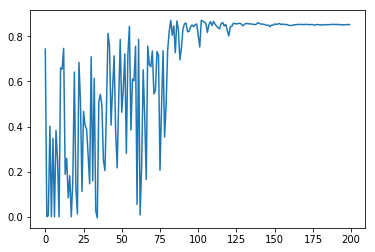

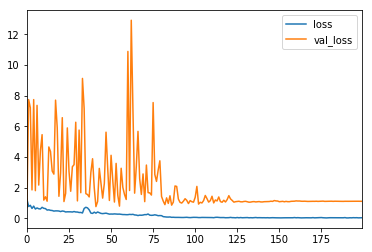

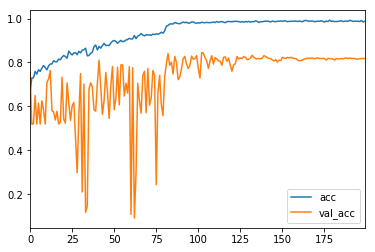

In [14]:

diagn_treino_model = model.predict(ident_treino)
diagn_treino_model = np.argmax(diagn_treino_model, axis=1)
diagn_treino_model = np.reshape(diagn_treino_model,(-1,1))

#diagn_treino_model = model.predict(ident_treino) > 0.5
#diagn_treino_model = diagn_treino_model.astype(int).sum(axis=1) - 1

diagn_treino_real = np.argmax(diagn_treino, axis=1)
diagn_treino_real = np.reshape(diagn_treino_real,(-1,1))

#diagn_treino_real = diagn_treino.astype(int).sum(axis=1) - 1

kappa = metrics.cohen_kappa_score(diagn_treino_model, diagn_treino_real, labels=(0,1,2,3,4), weights="quadratic")
print('quadratic-cohen-kappa:', kappa)

plt.plot(kappa_metrics.val_kappas)
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

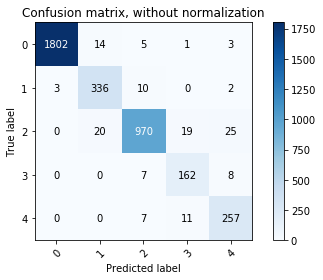

In [15]:
def plot_confusion_matrix(y_true, y_pred, classes,                         
                          title=None,
                          cmap=plt.cm.Blues):
   
    cm =  metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1,2,3,4]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(diagn_treino_model, diagn_treino_real, classes=(0,1,2,3,4),
                      title='Confusion matrix, without normalization')

plt.show()